# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp
import random
import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.models as models
from torchvision import datasets
from torchvision import transforms
from torchvision import models
import torchvision

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-3
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

### Optimizer

In [7]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [8]:
##################### Write your answer here ##################
# Define the loss function
criterion = nn.CrossEntropyLoss()
#criterion = FocalLoss(gamma=0.5, alpha=0.25)
###############################################################

In [9]:
def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ################## 
    output = model(image)
    loss = criterion(output, target)
    #output = model(image)
    
    ###############################################################

    return output, loss

In [10]:

def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    #output = model(image)
    output = model(image)
    loss = criterion(output, target)
    ###############################################################

    return output, loss

### Model Training

In [11]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
       # model = model.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0179 Acc: 0.1418
Begin test......
Test Loss: 0.0180 Acc: 0.1816
Epoch: 2/30 Train Loss: 0.0169 Acc: 0.2140
Begin test......
Test Loss: 0.0162 Acc: 0.2517
Epoch: 3/30 Train Loss: 0.0158 Acc: 0.2621
Begin test......
Test Loss: 0.0154 Acc: 0.3017
Epoch: 4/30 Train Loss: 0.0152 Acc: 0.2971
Begin test......
Test Loss: 0.0147 Acc: 0.3348
Epoch: 5/30 Train Loss: 0.0146 Acc: 0.3223
Begin test......
Test Loss: 0.0140 Acc: 0.3631
Epoch: 6/30 Train Loss: 0.0141 Acc: 0.3431
Begin test......
Test Loss: 0.0135 Acc: 0.3889
Epoch: 7/30 Train Loss: 0.0138 Acc: 0.3603
Begin test......
Test Loss: 0.0131 Acc: 0.4041
Epoch: 8/30 Train Loss: 0.0135 Acc: 0.3726
Begin test......
Test Loss: 0.0130 Acc: 0.4080
Epoch: 9/30 Train Loss: 0.0133 Acc: 0.3805
Begin test......
Test Loss: 0.0128 Acc: 0.4176
Epoch: 10/30 Train Loss: 0.0132 Acc: 0.3875
Begin test......
Test Loss: 0.0126 Acc: 0.4228
Epoch: 11/30 Train Loss: 0.0130 Acc: 0.3911
Begin test......
Test Loss: 0.0125 Acc: 0.4279
Epoch: 1

In [12]:
print(training_loss, training_acc, testing_loss, testing_acc)

[0.017942115960121154, 0.016937397861480713, 0.01578906981945038, 0.015183637795448303, 0.014606258308887482, 0.014089922697544098, 0.013773916692733765, 0.01352033378124237, 0.013335142149925231, 0.013157592742443085, 0.013036168637275697, 0.012958778665065765, 0.012886192119121552, 0.012848237297534943, 0.012771460342407226, 0.01275672396183014, 0.012712025673389435, 0.012681305236816407, 0.012697468588352204, 0.012604818496704102, 0.012604642255306244, 0.01258101713180542, 0.012584416415691376, 0.012585373108386994, 0.012536403632164001, 0.012540964040756226, 0.01253990790128708, 0.012521772356033325, 0.012497126693725586, 0.01250774155855179] [array(0.14184), array(0.21402), array(0.26214), array(0.29706), array(0.3223), array(0.34314), array(0.36028), array(0.3726), array(0.38052), array(0.3875), array(0.3911), array(0.40004), array(0.40132), array(0.40246), array(0.40672), array(0.40678), array(0.41076), array(0.41414), array(0.41002), array(0.4135), array(0.41558), array(0.41598

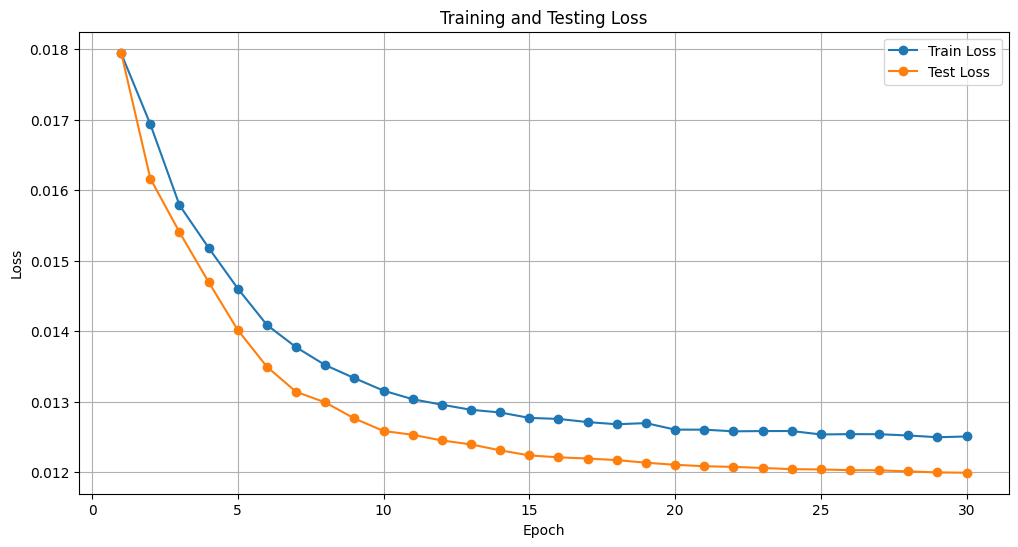

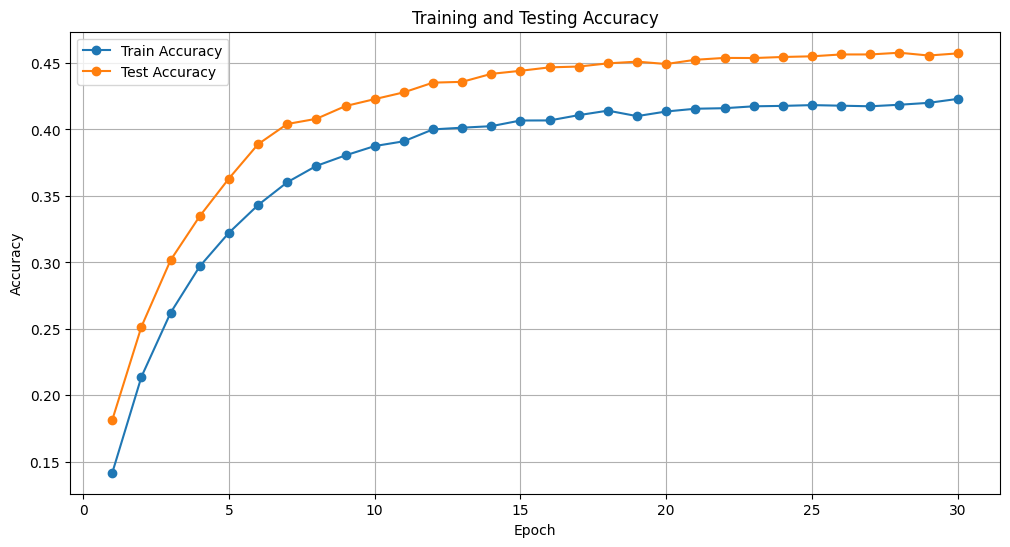

In [13]:
process_data = {
        'Epoch': list(range(1, NUM_EPOCHS + 1)),
        'Train Loss': training_loss,
        'Train Accuracy': training_acc,
        'Test Loss': testing_loss,
        'Test Accuracy': testing_acc,
}
plt.figure(figsize=(12, 6))
plt.plot(process_data['Epoch'], process_data['Train Loss'], label='Train Loss', marker='o')
plt.plot(process_data['Epoch'], process_data['Test Loss'], label='Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.grid(True)
plt.savefig('loss_plot.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(process_data['Epoch'], process_data['Train Accuracy'], label='Train Accuracy', marker='o')
plt.plot(process_data['Epoch'], process_data['Test Accuracy'], label='Test Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy')
plt.grid(True)
plt.savefig('accuracy_plot.png')
plt.show()


### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [14]:
def train_batch(model, image, target):
    # Perform one training batch iteration.
    output = model(image)
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(output, target)
    return output, loss


def test_batch(model, image, target):
    # Perform one testing batch iteration.
    output = model(image)
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(output, target)
    return output, loss


def train_and_evaluate(learning_rate, momentum, gamma, step, EVAL_INTERVAL):
    # Define your model, optimizer, and other necessary components
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    NUM_CLASS = 10
    BATCH_SIZE = 64
    NUM_EPOCHS = 30
    SAVE_DIR = './log'
    transform_cifar10_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_cifar10_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                             download=True, transform=transform_cifar10_train)

    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                                   shuffle=True, num_workers=2)

    test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                            download=True, transform=transform_cifar10_test)

    test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                                  shuffle=False, num_workers=2)
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    model = models.resnet18(weights='imagenet')
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, NUM_CLASS)
    model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step, gamma=gamma)

    for epoch in range(NUM_EPOCHS):
        model.train()
        torch.cuda.empty_cache()
        running_cls_loss = 0.0
        running_cls_corrects = 0

        for batch_idx, (image, target) in enumerate(train_dataloader):
            image = image.to(device)
            target = target.to(device)

            outputs, loss = train_batch(model, image, target)
            _, preds = torch.max(outputs, 1)

            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_cls_loss / len(train_set)
        epoch_acc = running_cls_corrects.double() / len(train_set)
        print(f'Epoch: {epoch + 1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        scheduler.step()

        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS:
            print('Begin test...')
            model.eval()
            val_loss = 0.0
            val_corrects = 0

            for batch_idx, (image, target) in enumerate(test_dataloader):
                image = image.to(device)
                target = target.to(device)

                outputs, loss = test_batch(model, image, target)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)

            val_loss = val_loss / len(test_set)
            val_acc = val_corrects.double() / len(test_set)
            print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

            if (epoch + 1) == NUM_EPOCHS:

                state = {
                    'state_dict': model.state_dict(),
                    'acc': epoch_acc,
                    'epoch': (epoch + 1),
                }

                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR)

                torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch + 1))))

In [15]:
inputs, classes = next(iter(test_dataloader))
inputs = inputs.to(device)
input = inputs[0]
input = input.to(device)

In [16]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################
with torch.no_grad():
        model.eval()
        output = model(input.unsqueeze(0))
        probabilities = torch.softmax(output, dim=1)
        predict_label = torch.argmax(probabilities, dim=1).item()
#probabilities = torch.softmax(output, dim=1)
#predict_label = torch.argmax(probabilities, dim=1)

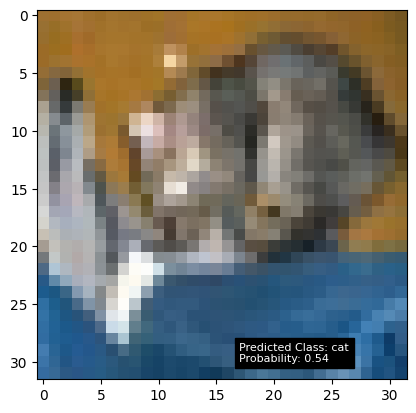

Print probabilities for each class:
airplane: 0.0130
automobile: 0.0189
bird: 0.0621
cat: 0.5414
deer: 0.0103
dog: 0.2227
frog: 0.0903
horse: 0.0037
ship: 0.0189
truck: 0.0187


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [17]:
predicted_class = class_names[predict_label]
predicted_probability = probabilities[0, predict_label].item()
image = input.cpu().numpy().transpose((1, 2, 0))
image = (image * np.array([0.2023, 0.1994, 0.2010])) + np.array([0.4914, 0.4822, 0.4465])
image = np.clip(image, 0, 1)
image = Image.fromarray((image * 255).astype(np.uint8))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[0,i].item():.4f}')
def train_and_evaluate(learning_rate, momentum, gamma, step, EVAL_INTERVAL):
    # 在这里定义 train_and_evaluate 函数，包含你的训练和评估逻辑
    # 返回训练好的模型
    model = models.resnet18(pretrained=False)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, NUM_CLASS)
    
    return model
if __name__ == '__main__':

    learning_rate = 0.1
    momentum = 0.5
    step = 5
    gamma = 0.9
    EVAL_INTERVAL = 30
    results = []

    SEED = 1
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)

    result = train_and_evaluate(learning_rate, momentum, gamma, step, EVAL_INTERVAL)